In [1]:
# Run code cell in case working in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set up Environment:
Required packages and libraries to be installed to be able to run all the code.

(Must run all the cells in this section before using this notebook)

In [2]:
# Required packages for Enhance Model
!pip install scikeras

In [8]:
# Import libraries
import os
import os.path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Import Dataset

In [4]:
# Load curated files
file_dir = "data/cur/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)

# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [5]:
# Pre-check data correctly loaded
num_labels =len(np.unique(labels))
print(f'num of labels = {num_labels}')
print(f'labels = {np.unique(labels)}')
print("-------------")


print(data.shape)
print(labels.shape)

num of labels = 5
labels = ['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']
-------------
(25000, 120, 120, 3)
(25000,)


In [6]:
# OneHotEncode target labels
encoder = OneHotEncoder(sparse_output=False)

# Reshape labels np.ndarray in order to be able to OneHotEncode them.
y_enc = np.array(encoder.fit_transform(labels.reshape(-1, 1)))

# Displaying dictionary that map labels to the corresponding one-hot-encoded value:
onehot_dict = {label: y_enc[i, :] for i, label in enumerate(labels)}
print(f"OneHotEncoded Dictionary:\n{onehot_dict}")

OneHotEncoded Dictionary:
{'Colon adenocarcinoma': array([0., 1., 0., 0., 0.]), 'Colon Benign Tissue': array([1., 0., 0., 0., 0.]), 'Lung adenocarcinoma': array([0., 0., 0., 0., 1.]), 'Lung Squamous Cell Carcinoma': array([0., 0., 0., 1., 0.]), 'Lung Benign Tissue': array([0., 0., 1., 0., 0.])}


## Visualizing Sample Images

In [ ]:
"""Randomly selecting 15 samples from the dataset. For each selected sample,
display the image along with its corresponding label as text on top of the image.
Arrange these images and labels in a single figure, ensuring that they are
visually clear and labeled properly."""

# Set up random state 42
np.random.seed(42)

# Randomly select 15 samples from the dataset
num_images_to_display = 16
indices_to_display = np.random.choice(data.shape[0], num_images_to_display, replace=False)


# Plot the images with their labels and instance numbers to be able to further check them.
fig_size = (16, 16)
plt.figure(figsize=fig_size)
for i, index in enumerate(indices_to_display, 1):
    plt.subplot(4, 4, i)
    plt.imshow(data[index])
    plt.title(f"Label: {labels[index]}")
    plt.axis('off')
    plt.text(0.5, -0.1, f"Instance: {index}", ha='center', va='center', fontsize=8, color='gray',
             transform=plt.gca().transAxes)

plt.tight_layout()
pdf.close()
plt.show()


In [ ]:
"""Export images to PDF available in /report/."""

# Set up random state 42
np.random.seed(42)

# Randomly select 15 samples from the dataset
num_images_to_display = 16
indices_to_display = np.random.choice(data.shape[0], num_images_to_display, replace=False)

# Create a PDF file for output
pdf_path = 'lung_colon_cancer_histopathological_image_classification/report/lung_colon_cancer_images.pdf'  # Adjust the path if needed
with PdfPages(pdf_path) as pdf:
    fig_size = (16, 16)
    plt.figure(figsize=fig_size)  # Set figure size

    for i, index in enumerate(indices_to_display, 1):
        plt.subplot(4, 4, i)
        plt.imshow(data[index])
        plt.title(f"Label: {labels[index]}")
        plt.axis('off')
        plt.text(0.5, -0.1, f"Instance: {index}", ha='center', va='center', fontsize=8, color='gray',
                transform=plt.gca().transAxes)

    plt.tight_layout()
    pdf.savefig()  # Save the figure to PDF
    plt.close()

# Confirm pdf stored
print(f"PDF created: {pdf_path}")

## Visualizing Class Distribution

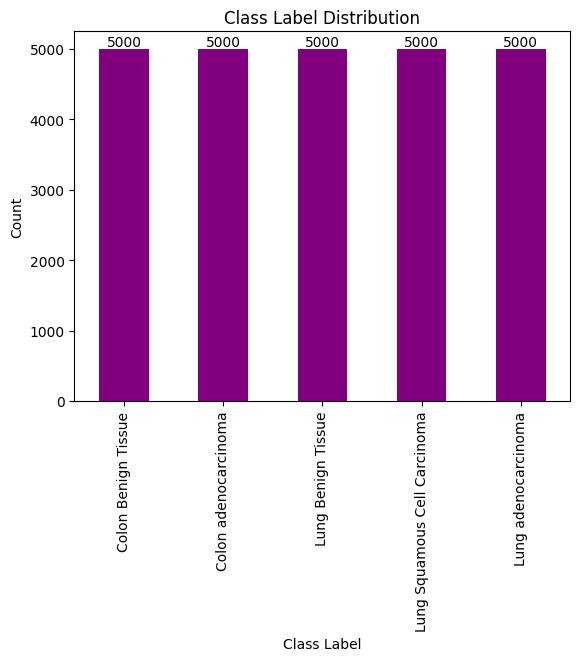

In [ ]:
# Creating pd DataFrame to easily plot each Classlabel distribution
class_dist_df = pd.DataFrame(labels, columns=['ClassLabel'])

# Plot class label distribution
class_dist_df['ClassLabel'].value_counts().sort_index().plot(kind='bar', color='purple')

# Add values on top of each bar
for i, v in enumerate(class_dist_df['ClassLabel'].value_counts()):
    class_dist_df['ClassLabel'].value_counts().sort_index().plot(kind='bar', color='purple').text(i, v + 1, f'{v}', ha='center', va='bottom', color='black')
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Creating pd DataFrame to easily plot each Classlabel distribution
class_dist_df = pd.DataFrame(labels, columns=['ClassLabel'])

# Plot class label distribution
class_dist_df['ClassLabel'].value_counts().sort_index().plot(kind='bar', color='purple')

# Path for saving PDF in Google Colab
pdf_path_dist = 'lung_colon_cancer_histopathological_image_classification/report/eda_class_distribution.pdf'

# Create a PDF file for output
with PdfPages(pdf_path_dist) as pdf:
    # Plot class label distribution
    ax = class_dist_df['ClassLabel'].value_counts().sort_index().plot(kind='bar', color='purple')
    plt.title('Class Label Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.ylim(0, 6000)  # Set the Y-axis limit to prevent labels to overlap header

    # Add values on top of each bar
    for i, v in enumerate(class_dist_df['ClassLabel'].value_counts().sort_index()):
        ax.text(i, v + 1, str(v), ha='center', va='bottom', color='black')

    plt.tight_layout()
    pdf.savefig()  # Save the current figure into a pdf page
    plt.close()  # Close the plt figure to avoid additional output in the notebook

# Inform the user that the PDF was created
print(f"PDF created: {pdf_path_dist}")

##Train-Test-Val Split

In [ ]:
"""Create train, validation, and test sets by performing stratified train-test splits with
 proportions of 60% for training, 20% for validation, and 20% for the test
 set, using a random seed of 42 for reproducibility."""

X_trainval, X_test, y_trainval, y_test = train_test_split(data, y_enc, test_size = 0.2, stratify=y_enc, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, stratify=y_trainval, random_state = 42)

# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [ ]:
## LOSS-ACC GRAPHS

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend(['training', 'validation'])
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend(['training', 'validation'])
    plt.tight_layout()
    plt.show()


In [ ]:
# Confussion Matrix and Classification Report function:

#Comment the code
def conf_matrix_classif_report(model, X_test, y_test):
  print("Predicting labels:")
  y_pred = model.predict(X_test)
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)
  conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
  classif_report = classification_report(y_test_labels, y_pred_labels)
  display(conf_matrix)
  print('')
  print(f"Classification Report:\n\n{classif_report}")
  print('')

  sns.set(font_scale=1.2)  # Adjust the font size if needed
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()




In [ ]:
# Code inspired from: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

# ROC curves
def roc_curves(model, X_test, y_test):
  y_pred = model.predict(X_test) # Predic labels using the pre-trained model

  for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:,i], y_pred[:,i]) # Compute ROC curve for the current class
    auc_score = roc_auc_score(y_test[:,i], y_pred[:,i]) # Calculate AUC score for the ROC curve
    # Plot ROC curve and class label together with AUC
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

  plt.plot([0, 1], [0, 1], linestyle='-')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Multi-class data')
  plt.legend(loc='lower right')
  plt.show()

# Baseline Model

In [ ]:
# Check number of labels & X_train shape
labels =len(np.unique(labels))
shape = X_train.shape[1:]

print(f"number of labels: {labels}")
print(f"Input Shape: {shape}")

number of labels: 5
Input Shape: (120, 120, 3)


In [ ]:
# Baseline model function according to assignment guidelines
def build_baseline_model(input_shape,num_labels):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = input_shape, padding="same"), # Including padding to obtain same output
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape = input_shape, padding="same"), # Including padding to obtain same output
      tf.keras.layers.MaxPooling2D((2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      # Output layer Size == #labels activation softmax as it's a Multiclass classification problem
      tf.keras.layers.Dense(num_labels, activation='softmax')
      ])
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
            metrics=['accuracy'])
  return model

In [ ]:
# Build Baseline Model and display summary
baseline_model = build_baseline_model(shape, labels)
baseline_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 120, 120, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 60, 60, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,454,597 (28.44 MB)

 Trainable params: 7,454,597 (28.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Baseline model using training data and validation split
baseline_history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
# Compute test loss and accuracy
test_loss, test_acc = baseline_model.evaluate(X_test, y_test)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.4575 - loss: 16.2886 - val_accuracy: 0.6588 - val_loss: 0.6891
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.6910 - loss: 0.6650 - val_accuracy: 0.7172 - val_loss: 0.5742
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.7364 - loss: 0.5499 - val_accuracy: 0.7158 - val_loss: 0.5763
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.7674 - loss: 0.5031 - val_accuracy: 0.7498 - val_loss: 0.5465
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8200 - loss: 0.4031 - val_accuracy: 0.7364 - val_loss: 0.6005
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8408 - loss: 0.3569 - val_accuracy: 0.7346 - val_loss: 0.6791
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8331 - loss: 0.3771 - val_accuracy: 0.7548 - val_loss: 0.6788
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8845 - loss: 0.2768 -

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


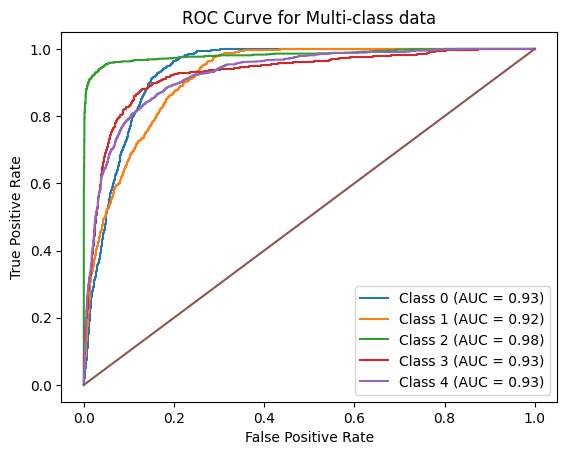

In [ ]:
 # Plot ROC curve and class label together with AUC for Baseline Model
roc_curves(baseline_model,X_test, y_test)

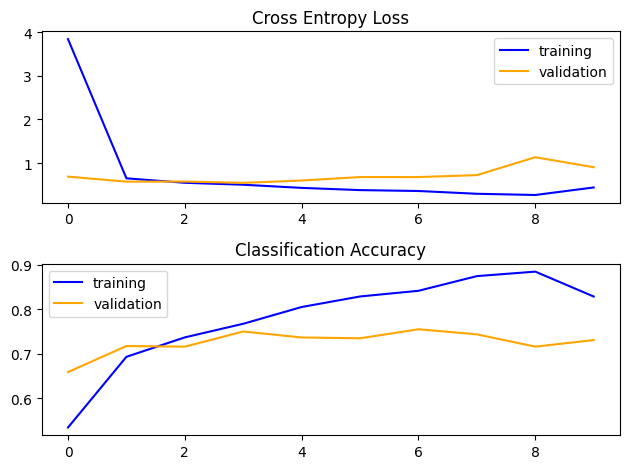

In [ ]:
# Loss and accuracy graph from Baseline model
summarize_diagnostics(baseline_history)

Predicting labels:
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([[726, 241,  16,   3,  14],
       [341, 567,  26,  37,  29],
       [ 23,  14, 899,   4,  60],
       [  0,   5,   0, 780, 215],
       [  4,   6,   4, 240, 746]])


Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1000
           1       0.68      0.57      0.62      1000
           2       0.95      0.90      0.92      1000
           3       0.73      0.78      0.76      1000
           4       0.70      0.75      0.72      1000

    accuracy                           0.74      5000
   macro avg       0.75      0.74      0.74      5000
weighted avg       0.75      0.74      0.74      5000




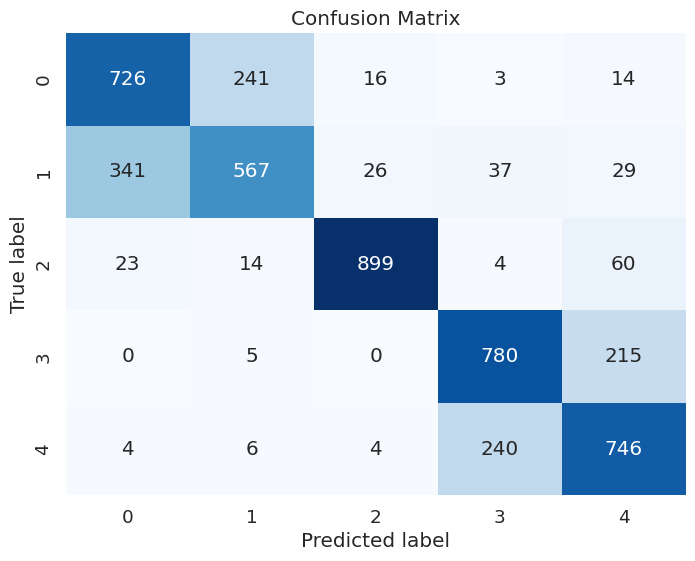

In [ ]:
# Confussion Matrix and Classification Report from Baseline Model
conf_matrix_classif_report(baseline_model, X_test, y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


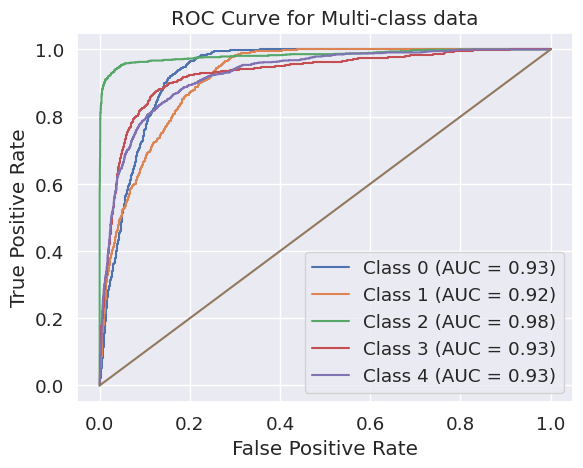

In [ ]:
 # Plot ROC curve and class label together with AUC for Baseline Model
roc_curves(baseline_model,X_test, y_test)

In [ ]:
# Saving model, to be able to switch to cpu in colab and still test functions.
# Save entire model
# Check function if model exist already, if not it saves a copy.
if os.path.isfile('lung_colon_cancer_histopathological_image_classification/models/model_trained/baseline_model.h5') is False:
  baseline_model.save('baseline_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load baseline model:
baseline_model = load_model('/content/drive/MyDrive/880663-M-6 Deep Learning Spring/assignment/models/baseline_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Create prediction to be used for testing functions
y_pred = baseline_model.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 111s 705ms/step


# Enhanced Model

In [ ]:
# reference code: https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html
# reference code: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

numb_labels =len(np.unique(labels))

# Define enhance model to be used for hyperparameter tuning
def create_enh_model(num_labels= numb_labels, optimizer='adam', kernel_size=(3, 3), filters=(128, 64), dense_units=(128,32)):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters[0], kernel_size, activation='relu', input_shape = X_train.shape[1:],padding="same"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(filters[1], kernel_size, activation='relu',strides=(1,1),padding="same"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(filters[1], kernel_size, activation='relu',strides=(1,1),padding="same"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(dense_units[0], activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.Dense(dense_units[1], activation='relu'),
  # Output layer Size == #labels activation softmax as it's a Multiclass classification problem
  tf.keras.layers.Dense(num_labels, activation='softmax')
  ])
  #model.compile(optimizer=optimizer,
   #             loss='categorical_crossentropy',
    #        metrics=['accuracy'])

  return model

# Define the hyperparameters to be tuned, resource limitation only tested optimizer.
param_grid_opt = {
    'optimizer': ['adam', 'sgd', 'rmsprop']
    #'kernel_size': [(3, 3), (5, 5)],
    #'filters': [(128, 64), (64, 128)]
    #'dense_units': [(128,32), (256,128)]
}

# Set up random State:
seed = 42
tf.random.set_seed(seed)

# Create the CNN model
model = KerasClassifier(build_fn=create_enh_model, loss='categorical_crossentropy', metrics='accuracy', epochs=5, batch_size=32, verbose=1)

# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid_opt, cv=2)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(X_train, y_train)

# Get the best parameters and their performance
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print("Best Parameters: ", best_params)
print("Best Accuracy: {:.2f}%".format(best_score * 100))

# Evaluate the best model on the validation set
best_model = grid_result.best_estimator_
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy of Best Model: {:.2f}%".format(val_accuracy * 100))
best_model

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
235/235 [==============================] - 30s 62ms/step - loss: 2.1826 - accuracy: 0.4779
Epoch 2/5
235/235 [==============================] - 13s 53ms/step - loss: 0.8385 - accuracy: 0.6964
Epoch 3/5
235/235 [==============================] - 10s 42ms/step - loss: 0.6743 - accuracy: 0.7809
Epoch 4/5
235/235 [==============================] - 10s 42ms/step - loss: 0.5723 - accuracy: 0.8264
Epoch 5/5
235/235 [==============================] - 2s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
235/235 [==============================] - 13s 46ms/step - loss: 4.0642 - accuracy: 0.3329
Epoch 2/5
235/235 [==============================] - 11s 45ms/step - loss: 1.1099 - accuracy: 0.5621
Epoch 3/5
235/235 [==============================] - 10s 44ms/step - loss: 0.8887 - accuracy: 0.6613
Epoch 4/5
235/235 [==============================] - 11s 45ms/step - loss: 0.8626 - accuracy: 0.6711
Epoch 5/5
235/235 [==============================] - 2s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
235/235 [==============================] - 10s 38ms/step - loss: nan - accuracy: 0.2029
Epoch 2/5
235/235 [==============================] - 9s 39ms/step - loss: nan - accuracy: 0.2033
Epoch 3/5
235/235 [==============================] - 9s 38ms/step - loss: nan - accuracy: 0.2033
Epoch 4/5
235/235 [==============================] - 9s 38ms/step - loss: nan - accuracy: 0.2033
Epoch 5/5
235/235 [==============================] - 2s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
235/235 [==============================] - 10s 39ms/step - loss: nan - accuracy: 0.1963
Epoch 2/5
235/235 [==============================] - 9s 39ms/step - loss: nan - accuracy: 0.1967
Epoch 3/5
235/235 [==============================] - 9s 39ms/step - loss: nan - accuracy: 0.1967
Epoch 4/5
235/235 [==============================] - 9s 38ms/step - loss: nan - accuracy: 0.1967
Epoch 5/5
235/235 [==============================] - 2s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
235/235 [==============================] - 12s 45ms/step - loss: 5.7711 - accuracy: 0.3184
Epoch 2/5
235/235 [==============================] - 10s 45ms/step - loss: 1.0859 - accuracy: 0.5553
Epoch 3/5
235/235 [==============================] - 10s 43ms/step - loss: 0.8860 - accuracy: 0.5992
Epoch 4/5
235/235 [==============================] - 10s 43ms/step - loss: 0.8569 - accuracy: 0.6479
Epoch 5/5
235/235 [==============================] - 2s 7ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
235/235 [==============================] - 11s 43ms/step - loss: 7.9817 - accuracy: 0.2353
Epoch 2/5
235/235 [==============================] - 10s 41ms/step - loss: 1.6349 - accuracy: 0.1949
Epoch 3/5
235/235 [==============================] - 10s 41ms/step - loss: 1.7642 - accuracy: 0.3377
Epoch 4/5
235/235 [==============================] - 9s 40ms/step - loss: 0.9243 - accuracy: 0.6213
Epoch 5/5
235/235 [==============================] - 2s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
469/469 [==============================] - 23s 46ms/step - loss: 1.7933 - accuracy: 0.5593
Epoch 2/5
469/469 [==============================] - 21s 44ms/step - loss: 0.7597 - accuracy: 0.7029
Epoch 3/5
469/469 [==============================] - 21s 44ms/step - loss: 0.6270 - accuracy: 0.7912
Epoch 4/5
469/469 [==============================] - 20s 43ms/step - loss: 0.5176 - accuracy: 0.8562
Epoch 5/5
469/469 [==============================] - 20s 43ms/step - loss: 0.4512 - accuracy: 0.8869
Best Parameters:  {'optimizer': 'adam'}
Best Accuracy: 78.51%
157/157 [==============================] - 1s 9ms/step
Validation Accuracy of Best Model: 86.00%


KerasClassifier(
	model=None
	build_fn=<function create_enh_model at 0x7a00453d4ca0>
	warm_start=False
	random_state=None
	optimizer=adam
	loss=categorical_crossentropy
	metrics=accuracy
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=5
	class_weight=None
)

In [ ]:
numb_labels =len(np.unique(labels))

# Baseline model function according to assignment guidelines
def create_enh_model(num_labels= numb_labels, optimizer='adam', kernel_size=(3, 3), filters=(128, 64), dense_units=(128,32)):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters[0], kernel_size, activation='relu', input_shape = X_train.shape[1:],padding="same"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(filters[1], kernel_size, activation='relu',strides=(1,1),padding="same"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(filters[1], kernel_size, activation='relu',strides=(1,1),padding="same"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(dense_units[0], activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.Dense(dense_units[1], activation='relu'),
  # Output layer Size == #labels activation softmax as it's a Multiclass classification problem
  tf.keras.layers.Dense(num_labels, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
            metrics=['accuracy'])

  return model

# Build Enhance Model and display summary
enh_model = create_enh_model(num_labels= numb_labels, optimizer='adam', kernel_size=(3, 3), filters=(128, 64), dense_units=(128,32))
enh_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 64)       

In [ ]:
# code from keras documentation: https://keras.io/api/callbacks/learning_rate_scheduler/
# code from keras documentation: https://keras.io/api/callbacks/early_stopping/

# Dynamic learning rate
def scheduler(epoch, lr):
  if epoch < 3: #Noticed with current architecture model tend to overfit at epoch 2
    return lr
  else:
    return lr * tf.math.exp(-0.2)

# Create a callback for early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train the enhanced model with callbacks
enh_history = enh_model.fit(X_train, y_train, epochs=15, batch_size=32,callbacks=[callback], validation_data=(X_val, y_val))

# Compute test loss and accuracy
test_loss, test_acc = enh_model.evaluate(X_test, y_test)

Epoch 1/15
469/469 [==============================] - 25s 49ms/step - loss: 1.3458 - accuracy: 0.5964 - val_loss: 0.6965 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 2/15
469/469 [==============================] - 22s 47ms/step - loss: 0.7238 - accuracy: 0.7350 - val_loss: 0.5511 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 3/15
469/469 [==============================] - 22s 46ms/step - loss: 0.5455 - accuracy: 0.8309 - val_loss: 0.4726 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 4/15
469/469 [==============================] - 21s 46ms/step - loss: 0.4131 - accuracy: 0.8851 - val_loss: 0.3467 - val_accuracy: 0.9112 - lr: 8.1873e-04
Epoch 5/15
469/469 [==============================] - 23s 48ms/step - loss: 0.3746 - accuracy: 0.8971 - val_loss: 0.4491 - val_accuracy: 0.8626 - lr: 6.7032e-04
Epoch 6/15
469/469 [==============================] - 21s 45ms/step - loss: 0.2989 - accuracy: 0.9255 - val_loss: 0.3747 - val_accuracy: 0.8914 - lr: 5.4881e-04
Epoch 7/15
469/469 [==========================

## Enhance model performance:

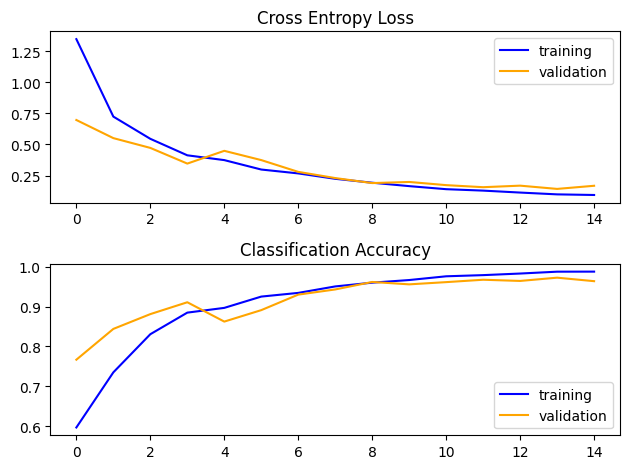

In [ ]:
# Loss and accuracy graph from Enhance model
summarize_diagnostics(enh_history)

Predicting labels:
157/157 [==============================] - 1s 7ms/step


array([[1000,    0,    0,    0,    0],
       [  42,  957,    0,    0,    1],
       [   1,    0,  995,    0,    4],
       [   0,    0,    0,  937,   63],
       [   2,    3,    3,   53,  939]])


Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1000
           1       1.00      0.96      0.98      1000
           2       1.00      0.99      1.00      1000
           3       0.95      0.94      0.94      1000
           4       0.93      0.94      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000




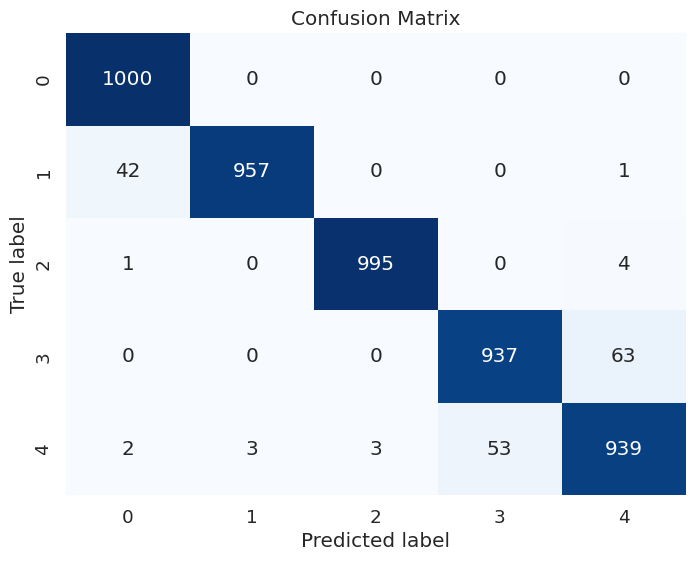

In [ ]:
# Confussion Matrix and Classification Report from Enhance Model
conf_matrix_classif_report(enh_model,X_test, y_test)

157/157 [==============================] - 1s 7ms/step


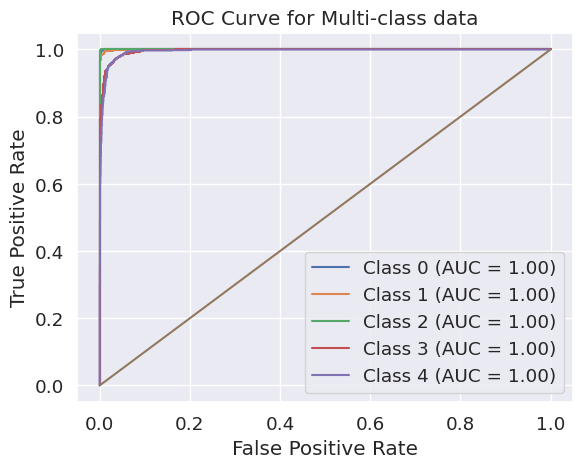

In [ ]:
# Plot ROC curve and class label together with AUC for Enhance Model
roc_curves(enh_model,X_test, y_test)

In [ ]:
# Check function if model exist already, if not it saves the enhance model.
if os.path.isfile('/content/drive/MyDrive/880663-M-6 Deep Learning Spring/assignment/models/enh_model.h5') is False:
  model.save('enh_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Transfer Learning Model


In [ ]:
# Load transfer learning model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# Select Transfer model. Note it needs to be previously imported from tf keras
transfer_model = VGG16

# Input shape: (120,120,3)
input_shape = X_train.shape[1:]

# Num.labels: 5
num_labels = len(np.unique(labels))

# Creating transfer model
def build_transfer_model(transfer_model, weights='imagenet',include_top=False, input_shape, num_labels):
  """
  Loading VGG16 model together with the imagnet weights,
  excluding dense connected layer and setting input shape to (120,120,3)
  """
  transfer_model = transfer_model(weights=weights, include_top=include_top, input_shape=input_shape)
  transfer_model.trainable = False
  model = tf.keras.models.Sequential([
  transfer_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  # Output layer Size == #labels activation softmax as it's a Multiclass classification problem
  tf.keras.layers.Dense(num_labels, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
            metrics=['accuracy'])
  return model

In [ ]:
# Plot ROC curve and class label together with AUC for Enhance Model
transfer_model = build_transfer_model(transfer_model, weights='imagenet',include_top=False, input_shape, num_labels)
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               589952    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 15308933 (58.40 MB)
Trainable params: 59

In [ ]:
# code from keras documentation: https://keras.io/api/callbacks/learning_rate_scheduler/
# code from keras documentation: https://keras.io/api/callbacks/early_stopping/

# Dynamic learning rate
def scheduler(epoch, lr):
  if epoch < 2: #Noticed with current architecture model tend to overfeet at epoch 2
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# Create a callback for early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train the transfer learning model with callbacks
transfer_history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32,callbacks=[callback], validation_data=(X_val, y_val))

# Compute test loss and accuracy
test_loss, test_acc = transfer_model.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 35s 71ms/step - loss: 1.0424 - accuracy: 0.7897 - val_loss: 0.3264 - val_accuracy: 0.9356 - lr: 0.0010
Epoch 2/10
469/469 [==============================] - 28s 59ms/step - loss: 0.4473 - accuracy: 0.8945 - val_loss: 0.3401 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 3/10
469/469 [==============================] - 31s 67ms/step - loss: 0.3773 - accuracy: 0.9130 - val_loss: 0.2778 - val_accuracy: 0.9498 - lr: 9.0484e-04
Epoch 4/10
469/469 [==============================] - 28s 61ms/step - loss: 0.3210 - accuracy: 0.9309 - val_loss: 0.2411 - val_accuracy: 0.9558 - lr: 8.1873e-04
Epoch 5/10
469/469 [==============================] - 28s 60ms/step - loss: 0.2875 - accuracy: 0.9349 - val_loss: 0.2349 - val_accuracy: 0.9526 - lr: 7.4082e-04
Epoch 6/10
469/469 [==============================] - 28s 60ms/step - loss: 0.2574 - accuracy: 0.9437 - val_loss: 0.2160 - val_accuracy: 0.9570 - lr: 6.7032e-04
Epoch 7/10
469/469 [======================

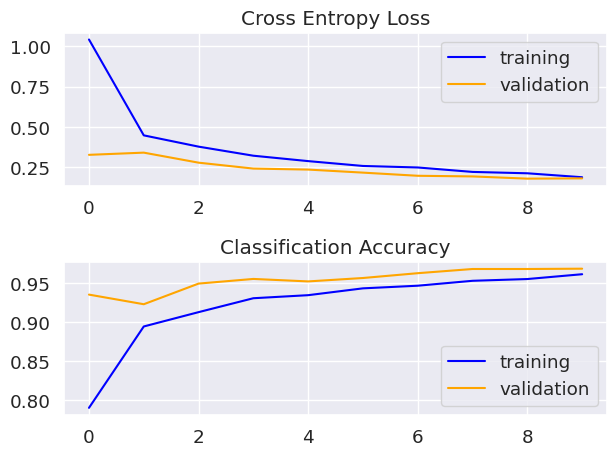

In [ ]:
# Loss and accuracy graph from Transfer learning model
summarize_diagnostics(transfer_history)

Predicting labels:
157/157 [==============================] - 7s 44ms/step


array([[990,   8,   2,   0,   0],
       [ 17, 970,   0,   4,   9],
       [  0,   0, 997,   0,   3],
       [  0,   0,   0, 961,  39],
       [  0,   6,   9,  53, 932]])


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       0.99      0.97      0.98      1000
           2       0.99      1.00      0.99      1000
           3       0.94      0.96      0.95      1000
           4       0.95      0.93      0.94      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000




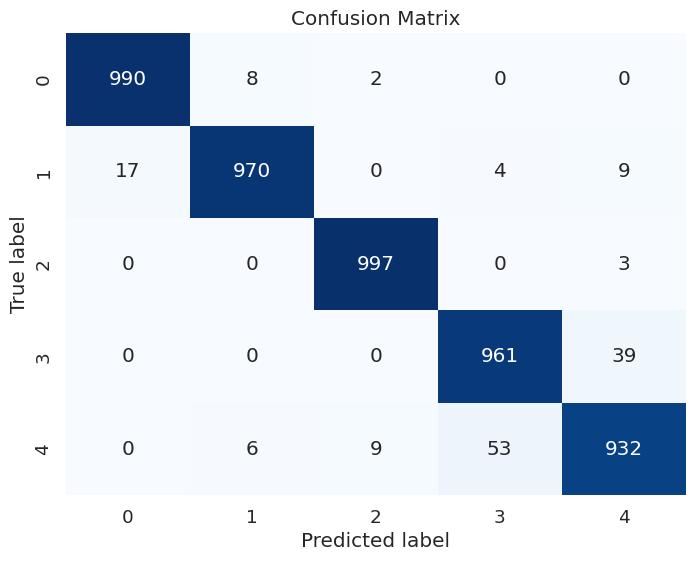

In [ ]:
# Confussion Matrix and Classification Report from Transfer learning Model
conf_matrix_classif_report(transfer_model,X_test, y_test)

157/157 [==============================] - 7s 45ms/step


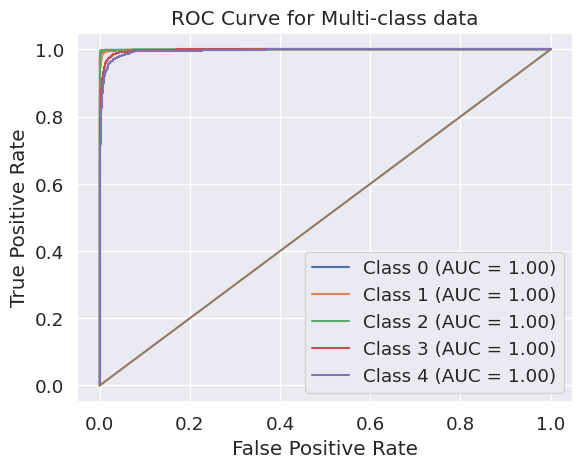

In [ ]:
# Plot ROC curve and class label together with AUC for Transfer learning Model
roc_curves(transfer_model,X_test, y_test)